## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

### <font style="color:lightblue">Configs</font>

In [2]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 3
    ,nofEpochs = 2048
    ,latentDim = 64
    ,batchSize = 25000 #32768
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.0002
    ,learningRateG = 0.0002
)

sg.DCfg = sg.DCfgClass(4)





### <font style="color:lightblue">Raw Read</font>

In [3]:
trainSet = sg.createTrainSet()
prepGdLoss=0

Loaded set 4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft


### <font style="color:lightblue">Show</font>

-4.103e-01, 3.013e-03, -4.175e-01, -3.937e-01


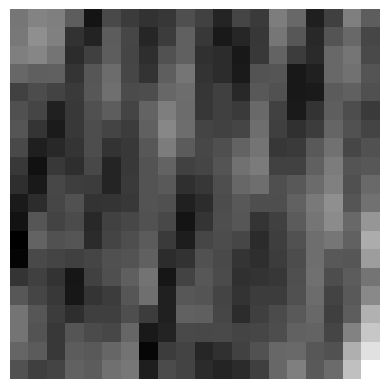

In [4]:

sg.refImages, sg.refNoises = sg.createReferences(trainSet, 3)
sg.showMe(trainSet, 0)


## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">LowRes generators</font>

In [5]:

class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        )
        sg.fillWheights(self.noise2latent)

        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)
        self.encode = nn.Sequential(
            encblock(  latentChannels+1, baseChannels, 3, norm=False),
            encblock(  baseChannels,     baseChannels, 3),
            encblock(  baseChannels,     baseChannels, 3),
            encblock(  baseChannels,     baseChannels, 3),
        )
        sg.fillWheights(self.encode)


        encSh = self.encode(torch.zeros((1,latentChannels+1,*self.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        sg.fillWheights(self.link)


        def decblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.ConvTranspose2d(chIn, chOut, kernel, stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)
        self.decode = nn.Sequential(
            decblock(baseChannels, baseChannels, (3,1)),
            decblock(baseChannels, baseChannels, (3,1)),
            decblock(baseChannels, baseChannels, (3,1)),
            decblock(baseChannels, baseChannels, (3,1), norm=False),
            nn.Conv2d(baseChannels, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)
        minv = modelIn.min(dim=-1).values.min(dim=-1).values
        ampl = modelIn.max(dim=-1).values.max(dim=-1).values - minv
        minv = minv[:,:,None,None]
        ampl = ampl[:,:,None,None]
        iampl = torch.where(ampl==0, 0, 2/ampl)
        modelIn = ( modelIn - minv ) * iampl - 1 # stretch
        latent = self.noise2latent(noises)
        modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        patches = self.body(modelIn) * 1.2 # 1.2 to allow for values outside (-1,1) range
        patches = ( patches + 1 ) * ampl / 2 + minv #destretch
        return sg.squeezeOrg(patches, orgDims)


    def preProc(self, images) :
        images = images.unsqueeze(0) # for the 2D case
        res = torch.zeros(images[self.gapRng].shape, device=images.device)
        res[...,0] += 2*images[...,self.gapRngX.start-1] +   images[...,self.gapRngX.stop]
        res[...,1] +=   images[...,self.gapRngX.start-1] + 2*images[...,self.gapRngX.stop]
        res = res.squeeze(0) # to compensate for the first squeeze
        return res/3


generator2 = Generator2()
generator2 = sg.load_model(generator2, model_path="gap2_gen.pt" )
generator2 = generator2.to(sg.TCfg.device)
generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()




/home/user/usr/src/sinogap/sinogap_module.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


### <font style="color:lightblue">Generator</font>

In [6]:
from torchvision import transforms

class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(4)

        latentChannels = 7
        self.noise2latent = nn.Sequential(
            nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
            nn.ReLU(),
            nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        )
        sg.fillWheights(self.noise2latent)

        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)
        self.encode = nn.Sequential(
            encblock(    latentChannels+1,   baseChannels, 3, norm=False),
            encblock(    baseChannels,     2*baseChannels, 3, stride=2),
            encblock(  2*baseChannels,     2*baseChannels, 3),
            encblock(  2*baseChannels,     2*baseChannels, 3),
        )
        sg.fillWheights(self.encode)


        encSh = self.encode(torch.zeros((1,latentChannels+1,*self.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.link = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        sg.fillWheights(self.link)


        def decblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.ConvTranspose2d(chIn, chOut, kernel, stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)
        self.decode = nn.Sequential(
            decblock(2*baseChannels, 2*baseChannels, (3,1)),
            decblock(2*baseChannels, 2*baseChannels, (3,1)),
            decblock(2*baseChannels,   baseChannels, (4,1), stride=(2,1)),
            decblock(  baseChannels,   baseChannels, (3,1), norm=False),
            nn.Conv2d( baseChannels, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.decode)


        self.body = nn.Sequential(
            self.encode,
            self.link,
            self.decode
        )


    def forward(self, input):
        images, noises = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)
        minv = modelIn.min(dim=-1).values.min(dim=-1).values
        ampl = modelIn.max(dim=-1).values.max(dim=-1).values - minv
        minv = minv[:,:,None,None]
        ampl = ampl[:,:,None,None]
        iampl = torch.where(ampl==0, 0, 2/ampl)
        modelIn = ( modelIn - minv ) * iampl - 1 # stretch
        latent = self.noise2latent(noises)
        modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        patches = self.body(modelIn) * 1.2 # 1.2 to allow for values outside (-1,1) range
        patches = ( patches + 1 ) * ampl / 2 + minv #destretch
        return sg.squeezeOrg(patches, orgDims)

    def preProc(self, images) :
        images, orgDims = sg.unsqeeze4dim(images)
        preImages = torch.nn.functional.interpolate(images, scale_factor=0.5, mode='area')
        prePatches = None
        with torch.inference_mode() :
            prePatches = generator2.generatePatches(preImages)
        prePatches = torch.nn.functional.interpolate(prePatches, scale_factor=2, mode='bilinear')
        return sg.squeezeOrg(prePatches, orgDims)



sg.generator = Generator()
sg.generator.to(sg.TCfg.device)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )




Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     [1, 1, 20, 4]             --
├─Sequential: 1-1                             [1, 7, 20, 20]            --
│    └─Linear: 2-1                            [1, 2800]                 182,000
│    └─ReLU: 2-2                              [1, 2800]                 --
│    └─Unflatten: 2-3                         [1, 7, 20, 20]            --
├─Sequential: 1-2                             [1, 1, 20, 4]             --
│    └─Sequential: 2-4                        [1, 128, 4, 4]            --
│    │    └─Sequential: 3-1                   [1, 64, 18, 18]           4,672
│    │    └─Sequential: 3-2                   [1, 128, 8, 8]            74,112
│    │    └─Sequential: 3-3                   [1, 128, 6, 6]            147,840
│    │    └─Sequential: 3-4                   [1, 128, 4, 4]            147,840
│    └─Sequential: 2-5                        [1, 128, 4, 4]            -

### <font style="color:lightblue">Discriminator</font>

In [7]:

class Discriminator(sg.DiscriminatorTemplate):

    def __init__(self):
        super(Discriminator, self).__init__()
        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)
        self.body = nn.Sequential(
            encblock(1,                baseChannels, 3, norm=False),
            encblock(  baseChannels, 2*baseChannels, 3, stride=2),
            encblock(2*baseChannels, 2*baseChannels, 3),
            encblock(2*baseChannels, 2*baseChannels, 3),
        )
        sg.fillWheights(self.body)

        encSh = self.body(torch.zeros((1,1,*sg.DCfg.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(linChannels, baseChannels*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(baseChannels*2, 1),
            nn.Sigmoid()
        )
        sg.fillWheights(self.head)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 128, 4, 4]            --
│    └─Sequential: 2-1                   [1, 64, 18, 18]           --
│    │    └─Conv2d: 3-1                  [1, 64, 18, 18]           640
│    │    └─LeakyReLU: 3-2               [1, 64, 18, 18]           --
│    └─Sequential: 2-2                   [1, 128, 8, 8]            --
│    │    └─Conv2d: 3-3                  [1, 128, 8, 8]            73,856
│    │    └─BatchNorm2d: 3-4             [1, 128, 8, 8]            256
│    │    └─LeakyReLU: 3-5               [1, 128, 8, 8]            --
│    └─Sequential: 2-3                   [1, 128, 6, 6]            --
│    │    └─Conv2d: 3-6                  [1, 128, 6, 6]            147,584
│    │    └─BatchNorm2d: 3-7             [1, 128, 6, 6]            256
│    │    └─LeakyReLU: 3-8               [1, 128, 6, 6]            --
│  

### <font style="color:lightblue">Optimizers</font>

In [8]:
sg.optimizer_G , sg.optimizer_D = sg.createOptimizers()

### <font style="color:lightblue">Restore checkpoint</font>

In [9]:
#sg.testMe(trainSet, 5)

Probabilities of reference images: Ref: 5.111e-01, Gen: 5.111e-01, Pre: 5.111e-01.
Distances of reference images: REC: 1.632e-01, MSE: 1.632e-01, L1L: 5.693e-01.


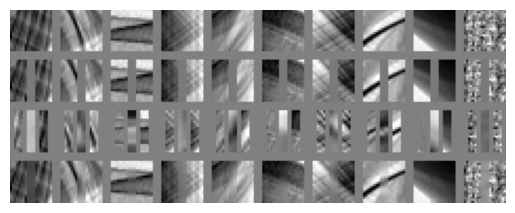

In [11]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss = sg.restoreCheckpoint(logDir=sg.TCfg.logDir+"_test")#savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir+"_test", True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 1984 (1904). Losses:  Dis: 0.325 (1.000), Gen: 0.403 (1.000), Rec: 8.285e-05 (8.182e-05 / 6.099e-04).
TT: 8.2477e-01 (43965,728),  FT: 9.0158e-01 (3284688,1835),  GP: 0.17171, 0.16481 
TF: 8.2336e-01 (3815618,1114),  FF: 5.0234e-01 (3885536,1546),  R : 0.15590 (5015896,2261)


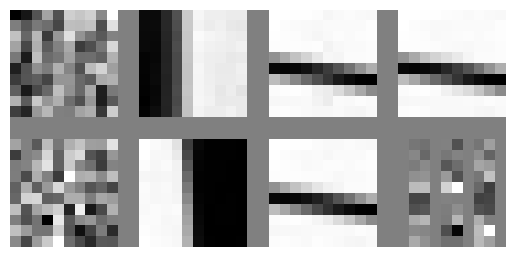

  6%|▌         | 12/209 [00:19<05:13,  1.59s/it]


KeyboardInterrupt: 

In [19]:
#torch.autograd.set_detect_anomaly(True)

#for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#    item['lr'] *= 0.5
trainLoader = sg.createTrainLoader(trainSet, num_workers=4)

sg.prepGdLoss = 0
if sg.prepGdLoss == 0:
    Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(trainLoader)
    sg.prepGdLoss = Rec_diff
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE0': MSE_diff
                          ,'L1L0': L1L_diff
                          ,'REC0': Rec_diff
                          }, 0 )
sg.lossDifCoef = 1000
try :
    sg.train(trainLoader, savedCheckPoint)
except :
    del trainLoader
    raise

# BatchNorm + Bias +, learning rate 2e-4

## <font style="color:lightblue">Post</font>

Index: ((5181589, 1514))
Probabilities. 8.280e-01,  8.753e-01,  8.747e-01.
Distances. Rec: 7.2679e-05,  MSE: 7.2679e-05,  L1L: 6.7282e-03.


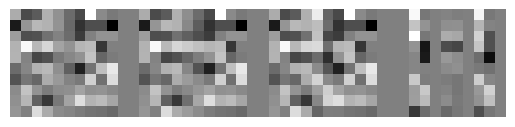

In [45]:
def testMe(tSet) :
    image, index, idxs = tSet.__getitem__(0)
    image = image.unsqueeze(0).to(sg.TCfg.device)
    colImgs, probs, dists = sg.generateDiffImages(image, layout=4)
    print(f"Index: ({index, idxs})")
    print(f"Probabilities. {probs[0,0]:.3e},  {probs[0,2]:.3e},  {probs[0,1]:.3e}.")
    print(f"Distances. Rec: {dists[0,0]:.4e},  MSE: {dists[0,1]:.4e},  L1L: {dists[0,2]:.4e}.")
    sg.plotImage(colImgs.squeeze().cpu())
testMe(trainSet)

### <font style="color:lightblue">Save results</font>

In [ ]:
#sg.saveModels()